In [1]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns

In [2]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                'V1A1F3 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                'V1A1F4 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                'V1A1F5 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',
                # 'V2A2F2 2026' :f'{mainpath}/V2A2F2_REV02_2026/',
                # 'V2A2F3 2026' :f'{mainpath}/V2A2F3_REV02_2026/',
                # 'V2A2F4 2026' :f'{mainpath}/V2A2F4_REV02_2026/', 
                # 'V2A2F5 2026' :f'{mainpath}/V2A2F5_REV02_2026/',
                # 'V3A3F2 2026' :f'{mainpath}/V3A3F2_REV1_2026/',
                # 'V3A3F3 2026' :f'{mainpath}/V3A3F3_REV1_2026/',
                # 'V3A3F4 2026' :f'{mainpath}/V3A3F4_REV1_2026/',
                # 'V3A3F5 2026' :f'{mainpath}/V3A3F5_REV1_2026/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'), 
                (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'), 
                (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'),  
                (dirPotencia+'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'), 
                (dirPotencia+'Df_Reserva_PO_MVAR.csv', 'pot_mvar_reserv'),
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]

intense_palette = sns.color_palette("bright", 10)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}

In [3]:
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

In [4]:
# Function to calculate indices for lines
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # df_r_nt['PFI'] = df_r_nt['MW_Flow'] / df_r_nt['MVA']
    df_r_nt['Mva_index'] = df_r_nt['PI_mva'] ** (1 / (2 * n))

    return df_r_nt

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['key','Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['key','Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2], index[3]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['key','Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, : ,reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures(df_nt, df_ger, dfpq, dfpv):
    # Step 1: Merge DataFrames with only necessary columns
    dfpq_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'CSI_INF', 'CSI_SUP']
    dfpv_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'CSI_INF', 'CSI_SUP']

    datafeatures_pq = df_nt.merge(dfpq[dfpq_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')
    datafeatures_pq = datafeatures_pq[['BUS_ID', 'BUS_NAME', 'ARE', 'VBASEKV', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'B0_MVAR']]

    datafeatures_pv = df_ger.merge(dfpv[dfpv_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'], how='left')
    datafeatures_pv = datafeatures_pv[['BUS_ID', 'BUS_NAME', 'ARE', 'Gen_Type', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'PG_MW', 'QG_MVAR']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['Importance_inf'] = datafeatures_pq['IndiceInf'] / datafeatures_pq['CSI_INF'].replace(0, np.nan)
    datafeatures_pq['Importance_sup'] = datafeatures_pq['IndiceSup'] / datafeatures_pq['CSI_SUP'].replace(0, np.nan)

    datafeatures_pv['Importance_inf'] = datafeatures_pv['IndiceInf'] / datafeatures_pv['CSI_INF'].replace(0, np.nan)
    datafeatures_pv['Importance_sup'] = datafeatures_pv['IndiceSup'] / datafeatures_pv['CSI_SUP'].replace(0, np.nan)

    # Step 3: Filter rows directly without fillna
    datafeatures_pq = datafeatures_pq[datafeatures_pq['B0_MVAR'].notna() & (datafeatures_pq['B0_MVAR'] != 0)]
    datafeatures_pv = datafeatures_pv[datafeatures_pv['QG_MVAR'].notna() & (datafeatures_pv['QG_MVAR'] != 0)]

    # Optional: Fill NaN values in other columns with zero if necessary
    datafeatures_pq.fillna(0, inplace=True)
    datafeatures_pv.fillna(0, inplace=True)
    
    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    dfeatures_pv = datafeatures_pv.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'Gen_Type': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nbuses = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_inf', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_sup', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    result_inf_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_inf', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_sup', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    
    # Step 6: Filter by BUS_ID
    features_inf_pq = result_inf_pq[result_inf_pq['Importance_inf'] != 0]
    features_sup_pq = result_sup_pq[result_sup_pq['Importance_sup'] != 0]
    features_inf_pv = result_inf_pv[result_inf_pv['Importance_inf'] != 0]
    features_sup_pv = result_sup_pv[result_sup_pv['Importance_sup'] != 0]
    
    # Step 7: Pivot tables
    def pivot_table(df, values_list, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column='BUS_NAME'):
        filtered_df = df[df['BUS_ID'].isin(values_list)]
        pivot_df = filtered_df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df
    
    features_sup_pq_df = pivot_table(df_nt, features_sup_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_inf_pq_df = pivot_table(df_nt, features_inf_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_sup_pv_df = pivot_table(df_ger, features_sup_pv['BUS_ID'].to_list(), 'QG_MVAR')
    features_inf_pv_df = pivot_table(df_ger, features_inf_pv['BUS_ID'].to_list(), 'QG_MVAR')
    
    return features_sup_pq_df, features_inf_pq_df, features_sup_pv_df, features_inf_pv_df

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures_2(df_nt, df_r_nt):

    datafeatures_pq = df_nt.merge(df_r_nt, on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')[['From#', 'To#', 'From Name', 'To Name', '% L1', 'Mvar:Losses', 'Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'Mva_index']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['importance_lines'] = datafeatures_pq['% L1'] / datafeatures_pq['Mva_index'].replace(0, np.nan)
    datafeatures_pq.fillna(0, inplace=True)

    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby(['From#', 'To#']).agg({
        'importance_lines': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'From Name': 'first',
        'To Name':'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nlines = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'importance_lines', nlines)[['REG', 'VBASEKV','From#', 'To#', 'From Name', 'To Name','importance_lines']]
    result_inf_pq = result_inf_pq.set_index(['From Name', 'To Name'])
    mask = df_nt[['From Name', 'To Name']].apply(tuple, axis=1)
    filteredlines = df_nt[mask.isin(result_inf_pq.index)]

    # Step 7: Pivot tables
    def pivot_table(df, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column=['From Name', 'To Name']):
        pivot_df = df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df

    features_inf_pq_df = pivot_table(filteredlines, ['% L1', 'Mvar:Losses'])
    # features_inf_pq_df = pivot_table(filteredlines, ['MW_Flow'])
    features_inf_pq_df.columns = [' |'.join(filter(None, col)).strip() for col in features_inf_pq_df.columns]

    return  features_inf_pq_df

# Function to filter data based on non-convergent conditions
def filtarNC(df_list):
    df_filtrado = []
    for df_ in df_list:
        cenario = df_['Cenario'][0]
        bool_PWF_NConv = df_indice_grop[
            df_indice_grop['Cenario'] == cenario
        ][['Dia', 'Hora']].apply(tuple, axis=1)
        filtro = df_[['Dia', 'Hora']].apply(tuple, axis=1).isin(bool_PWF_NConv)
        df_filtrado.append(df_[filtro])
    return df_filtrado

# Function to concatenate and process data (part 1)
def concatenation_1():
    data = {}
    
    print('====== Selecting Critical Buses as features ======')
    ddffpv = pd.concat(dfs['IndexDec_PV'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'key'])
    ddffpq = pd.concat(dfs['IndexDec_PQ'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'key'])
    Df_ger = pd.concat(dfs['ger'], axis=0)
    Df_nt = pd.concat(dfs['nt'], axis=0)
    data['features_sup_pq_df'], data['features_inf_pq_df'], data['features_sup_pv_df'], data['features_inf_pv_df'] = computefeatures(Df_nt, Df_ger, ddffpq.reset_index(), ddffpv.reset_index())
    
    print('====== Selecting Critical Lines as features ======')
    data['df_linhas'] = pd.concat(dfs['linhas'], axis=0)
    data['df_linhas'] = data['df_linhas'][(data['df_linhas']['L1(MVA)']!=9999) & (data['df_linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
    dfl_r_nt = IndiceLinhas(data['df_linhas'], 2)
    data['features_lines'] = computefeatures_2(data['df_linhas'], dfl_r_nt.reset_index())

    print('====== Concatenation of Other Data ======')
    data['df_DPI'] = pd.concat([flatdf(ddffpq, 'VBASEKV'), flatdf(ddffpv, 'Gen_Type')], axis=1)
    data['df_ger_reg_concat'] = pd.concat(filtarNC(dfs['ger_reg']), axis=0)
    data['df_indice_group'] = pd.concat(dfs['Index_Modif'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    df_intercambios_01 = pd.concat(dfs['intercambios'], axis=0).rename(columns={'Intercambio AC': 'Intercambio'})
    df_hvdc_01 = pd.concat(dfs['HVDC'], axis=0).rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'})
    df_Indice_REG = pd.concat(dfs['Index'], axis=0).rename(columns={'level_0': 'Indice'})
    data['df_Trafo'] = pd.concat(dfs['Trafo'], axis=0).rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
    data['df_reserva'] = pd.concat(dfs['pot_mw_reserv'], axis=0).set_index(['Dia', 'Hora', 'Cenario'])

    df_intercambios_01 = df_intercambios_01.set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
    df_hvdc_01 = df_hvdc_01.set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
    data['df_indice_grop'] = df_indice_grop.set_index(['key','Dia', 'Hora', 'Cenario'])
    data['df_indice_group'] = data['df_indice_group'].set_index(['key','Dia', 'Hora', 'Cenario'])
    data['df_Indice_REG'] = df_Indice_REG.set_index(['Indice', 'key','Dia', 'Hora', 'REG', 'Cenario'])

    concatenated_HVDC = pd.concat([
        df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
        df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
        df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
        # df_hvdc_01.loc[:,:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
    ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])

    concatenated_FluxoAC = pd.concat([
        df_intercambios_01.loc[:,:, :, :, 'EXP_NE']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-N']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-SE']['MW:From-To'], 
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_N-S']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']

    ], axis=1, keys=['EXP_NE', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_N-S','Fluxo_SUL-SECO'])

    data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['key','Dia', 'Hora', 'Cenario'], how='left')
    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):
    print('====== Start processing (PO) ======')
    Df_ger = pd.concat(dfs['ger'], axis=0)

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    G_Uhe_230_ACRO = [6888, 6892, 6891]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]
    AngraI = [10]
    AngraII = [11]
    TPires = [4492]
    S_Mesa = [36]
    XINGO = [5061]
    Furnas = [16]

    DF_complete_PO = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['key','Dia', 'Hora', 'Cenario']).sum(numeric_only=True)
    DF_complete_PO = data['df_indice_group'].merge(DF_complete_PO, on=['key','Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])

    Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt + G_Uhe_230_ACRO+AngraI+AngraII+TPires+S_Mesa+XINGO+Furnas)]
    DF_complete_PO[['Jirau_MW', 'Jirau_MVAR', 'Jirau_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR', 'S_Antonio_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR', 'Tucurui_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve',]].sum()
    DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR', 'B_Monte_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_50_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR', 'Itaipu_60_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR', 'I_Solt_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['G_ACRO_230_MW', 'G_ACRO_230_MVAR', 'G_ACRO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(G_Uhe_230_ACRO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['AngraI_MW', 'AngraI_MVAR', 'AngraI_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraI)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['AngraII_MW', 'AngraII_MVAR', 'AngraII_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraII)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['TPires_MW', 'TPires_MVAR', 'TPires_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(TPires)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['S_Mesa_MW', 'S_Mesa_MVAR', 'S_Mesa_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Mesa)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['XINGO_MW', 'XINGO_MVAR', 'XINGO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(XINGO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
    DF_complete_PO[['Furnas_MW', 'Furnas_MVAR', 'Furnas_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Furnas)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Start processing (REG) ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)

    df_Trafo_grouped_REG = data['df_Trafo'][data['df_Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
    
    DF_complete_PO_REG = df_linhas_grouped_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
    df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
    df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    Df_data_completo_reg = df_REG_Cenario_PQ[['OV DPI', 'UV DPI']].merge(df_REG_Cenario_PV, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':
    print('Reading data...')
    dfs = read_data()
    df_indice_grop = pd.concat(dfs['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1()
    
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
                }
    
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')


Reading data...
Concatenating data...
====== Selecting Critical Buses as features ======


C:\Users\david\AppData\Local\Temp\ipykernel_45916\4098459042.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
C:\Users\david\AppData\Local\Temp\ipykernel_45916\4098459042.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(dro

====== Selecting Critical Lines as features ======


C:\Users\david\AppData\Local\Temp\ipykernel_45916\4098459042.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)


====== Concatenation of Other Data ======
====== Start processing (PO) ======
====== Start processing (REG) ======


In [5]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [6]:
def indice_reativo (df, tg, pinf: bool):
    df = df.copy()
    if pinf:
        pass
    else:
        n=2
        if tg == 'Gen_Type':
            df['Ind_Qmin'] = df['ReservaIND'] ** (2 * n)
            df['Ind_Qmax'] = df['ReservaCAP'] ** (2 * n)
            df1 = df.groupby(['key','Dia', 'Hora', 'Cenario', 'REG', tg]).agg({'Ind_Qmin': 'sum', 'Ind_Qmax': 'sum'})
            df1['Qmin_norm'] = df1['Ind_Qmin']**(1 / (2 * n))
            df1['Qmax_norm'] = df1['Ind_Qmax']**(1 / (2 * n))
        else:
            df['Ind_Qmin'] = df['ReservaINDshunt'] ** (2 * n)
            df['Ind_Qmax'] = df['ReservaCAPshunt'] ** (2 * n)
            df1 = df.groupby(['key','Dia', 'Hora', 'Cenario', 'REG', tg]).agg({'Ind_Qmin': 'sum', 'Ind_Qmax': 'sum'})
            df1['Qmin_norm'] = df1['Ind_Qmin']**(1 / (2 * n))
            df1['Qmax_norm'] = df1['Ind_Qmax']**(1 / (2 * n))  
        
    return df1[['Qmin_norm', 'Qmax_norm']]

# mask_inseguros = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 1).any(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

# mask_inseguros = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 0.2).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

mask_inseguros = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 0.2).any(axis=1)]
mask_inseguros = mask_inseguros.loc[(mask_inseguros[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 1).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

df_ger = pd.concat(dfs['ger'], axis=0)
df_ger = df_ger.set_index('REG').rename(index=regionmap, level='REG').reset_index()
df_nt = pd.concat(dfs['nt'], axis=0)
df_nt = df_nt.set_index('REG').rename(index=regionmap, level='REG').reset_index()

filtro1 = (df_ger[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(mask_inseguros))
df_filt_ger = df_ger[filtro1]
filtro2 = (df_nt[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(mask_inseguros))
df_filt_nt = df_nt[filtro2]

dfqind1 = indice_reativo(df_filt_ger,'Gen_Type',False)
dfqind2 = indice_reativo(df_filt_nt,'VBASEKV',False)
DATA['df_Qind'] = pd.concat([flatdf(dfqind2, 'VBASEKV'), flatdf(dfqind1, 'Gen_Type')], axis=1)

In [7]:
def separaFERV_Load(df, condition, Load = False ):
    if Load == False:
        dff = df.reset_index().merge(DF_complete_PO[['PG_FERV']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PG_FERV'] > condition[0]) & (dff['PG_FERV'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])
    else:
        dff = df.reset_index().merge(DF_complete_PO[['PL_MW']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PL_MW_y'] > condition[0]) & (dff['PL_MW_y'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])   
        dff = dff.drop(columns='PL_MW_y').rename(columns={'PL_MW_x':'PL_MW'})  
    return dff

def reorder_and_filter(df, cenario, region, columns):
    df = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG'])[columns]
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        elif region == 'PO':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, :, region]
    else:
        if region == 'all':
            df_reordered = df.loc[:, :, cenario, :]
        elif region == 'PO':
            df_reordered = df.loc[:, :, cenario]
        else:
            df_reordered = df.loc[:, :, cenario, region]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['Dia', 'Hora', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora'], how='left')

def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux=True, Reserva=False, IndiceGroup=False, DPI=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures = False, Vanalysis = None,Linefeatures = False, Q_indice = False):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    columns (list): The columns to include in the flattened dataframe.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    IndiceGroup (bool): Include index group data.
    DPI (bool): Include DPI data.
    InfoPO (bool): Include PO info.
    PImva_reg_nt (bool): Include PImva region NT data.
    PImva (bool): Include PImva data.

    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region, columns)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1], index[2]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'][[' Reserve']], cenario, 'Reserva')
    if IndiceGroup:
        datapd = merge_data(datapd, DATA['df_indice_group'], cenario, 'IndiceGroup')
    if DPI:
        datapd = merge_data(datapd, DATA['df_DPI'], cenario, 'DPI')
    # if PImva:
    #     datapd = merge_data(datapd, dfl_po[['PI_mva', 'PFI']], cenario, 'PImva')
    # if PImva_reg_nt:
    #     dff = flatdf(dfl_r_nt[['PI_mva', 'PFI']], 'VBASEKV')
    #     datapd = merge_data(datapd, dff, cenario, 'PImva_reg_nt')
    if Q_indice:
        datapd = merge_data(datapd, DATA['df_Qind'], cenario, 'df_Qind')
    if InfoPO:
        column = ['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper', 'PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR', 'Shunt_Ind', 'Shunt_Cap', 'SHUNT_INST_IND',
                    'SHUNT_INST_CAP', 'ReservaIND', 'ReservaCAP', 'PG_BIO', 'PG_Dist', 'QG/QL', 'PG/PL', 'ReservaINDshunt', 'ReservaCAPshunt']
        dfPO = DF_complete_PO.drop(columns=column)
        datapd = merge_data(datapd, dfPO, cenario, 'InfoPO')
    if Busfeatures:
        if Vanalysis == 'OV':
            df_aux = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_sup')
            # datapd = merge_data(datapd, DATA['features_sup_pv_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_sup_pq_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
        elif Vanalysis == 'UV':
            df_aux = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_inf')
            # datapd = merge_data(datapd, DATA['features_inf_pv_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_inf_pq_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
    if Linefeatures:
        datapd = merge_data(datapd, DATA['features_lines'], cenario, 'features_lines').set_index(['Dia', 'Hora', 'Cenario'])

    datapd.columns = datapd.columns.astype(str)
    return datapd

In [8]:
column = ['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper', 'PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR', 'Shunt_Ind', 'Shunt_Cap', 'SHUNT_INST_IND',
            'SHUNT_INST_CAP', 'ReservaIND', 'ReservaCAP', 'PG_BIO', 'PG_Dist', 'QG/QL', 'PG/PL', 'ReservaINDshunt', 'ReservaCAPshunt']
DF_complete_PO.drop(columns=column)

,,,,PG_UHE,PG_UTE,PG_EOL,PG_SOL,PG_FERV,DL_MW,Jirau_MW,Jirau_MVAR,Jirau_Reserva,S_Antonio_MW,...,TPires_Reserva,S_Mesa_MW,S_Mesa_MVAR,S_Mesa_Reserva,XINGO_MW,XINGO_MVAR,XINGO_Reserva,Furnas_MW,Furnas_MVAR,Furnas_Reserva
key,Dia,Hora,Cenario,,,,,,,,,,,,,,,,,,,,,
D_1_H_00-00,1,00-00,V1A1F2 2026,38641.533,13977.509,15575.539,34.914,0.232556,51515.011,234.104,3.536,0.00,499.266,...,0.00,240.850,109.153,179.15,424.336,-23.598,0.0,221.296,-78.392,82.70
D_1_H_00-30,1,00-30,V1A1F2 2026,36884.508,14064.683,15594.335,36.344,0.238510,49903.919,248.565,7.450,0.00,499.788,...,0.00,281.113,110.182,138.89,441.942,-16.002,0.0,0.000,0.000,0.00
D_1_H_01-00,1,01-00,V1A1F2 2026,35375.531,13944.900,15466.265,48.210,0.242985,48335.053,262.520,8.590,0.00,499.851,...,0.00,244.415,91.234,175.59,420.570,-13.698,0.0,0.000,0.000,0.00
D_1_H_01-30,1,01-30,V1A1F2 2026,34263.048,13688.174,15233.331,32.290,0.243887,47327.397,275.755,11.855,0.00,499.635,...,0.00,240.374,-6.832,179.63,390.290,-14.154,0.0,0.000,0.000,0.00
D_1_H_02-00,1,02-00,V1A1F2 2026,33515.417,14014.322,14795.800,30.022,0.240963,46701.545,288.385,12.775,0.00,499.059,...,0.00,240.413,24.732,179.59,405.008,-14.664,0.0,0.000,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D_28_H_21-30,28,21-30,V1A1F5 2026,54359.990,15747.652,15572.554,51.665,0.187870,67540.629,1170.173,-45.589,479.64,2475.592,...,419.18,321.344,84.985,98.66,671.152,13.664,0.0,1064.000,-42.413,0.00
D_28_H_22-00,28,22-00,V1A1F5 2026,52530.122,15450.273,15651.596,53.699,0.192464,65896.125,994.991,-25.932,429.89,2872.520,...,485.09,340.148,77.980,499.85,489.444,0.582,0.0,1064.000,-70.084,0.00
D_28_H_22-30,28,22-30,V1A1F5 2026,51010.490,15333.048,15631.383,44.877,0.195990,64308.905,859.420,-56.779,415.33,2874.446,...,398.41,311.135,21.599,108.87,466.004,-0.846,0.0,1064.000,-80.493,0.00


In [9]:
def reduce_dimension(data, tsne=False):
    """
    Reduces the dimensionality of the given data using PCA or t-SNE.
    """
    if data.shape[1] > 2:
        if tsne:
            tsne_model = TSNE(n_components=2, perplexity=55, random_state=42)
            reduced_data = tsne_model.fit_transform(data)
        else:
            pca = PCA(n_components=2)
            reduced_data = pca.fit_transform(data)
            # explained_variance_ratio = pca.explained_variance_ratio_
            # cumulative_explained_variance = np.cumsum(explained_variance_ratio)
            # print(f"Cumulative Explained Variance: {cumulative_explained_variance}")
    else:
        reduced_data = data if not tsne else TSNE(n_components=2, perplexity=55, random_state=42).fit_transform(data)
    return reduced_data

def kmeans_clustering(x_train_pca, num_clusters_list, clusters_dbscan=False, clusters_hc=False, clusters_sc=False, tsne=False, metric=None, param_dbscan=None):
    """
    Performs KMeans clustering on the given data and visualizes the results.
    """
    cluster_results = []
    for num_clusters in num_clusters_list:
        print(num_clusters)

        kmeans = KMeans(n_clusters=num_clusters, max_iter=10000, n_init=100, init='k-means++', random_state=42)
        if clusters_dbscan:
            cluster_labels = DBSCAN(eps=param_dbscan[0], min_samples=param_dbscan[1]).fit_predict(x_train_pca)
        elif clusters_hc:
            cluster_labels = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward').fit_predict(x_train_pca)
        elif clusters_sc:
            cluster_labels = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors').fit_predict(x_train_pca)
        else:
            if metric:
                kmeans.set_params(metric=metric)
            cluster_labels = kmeans.fit_predict(x_train_pca)

        cluster_results.append(cluster_labels)

        silhouette_avg = silhouette_score(x_train_pca, cluster_labels)
        print(f"For num_clusters = {num_clusters}, The average silhouette_score is: {silhouette_avg:.4f}")

        metric1 = davies_bouldin_score(x_train_pca, cluster_labels)
        metric2 = calinski_harabasz_score(x_train_pca, cluster_labels)
        print(f"Davies-Bouldin index: {metric1:.4f}")
        print(f"Calinski-Harabasz index: {metric2:.4f}")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(x_train_pca) + (num_clusters + 1) * 10])

        sample_silhouette_values = silhouette_samples(x_train_pca, cluster_labels)
        y_lower = 10
        for i in range(num_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / num_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.8)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        X2d = reduce_dimension(x_train_pca, tsne=tsne)
        colors = cm.nipy_spectral(cluster_labels.astype(float) / num_clusters)
        ax2.scatter(X2d[:, 0], X2d[:, 1], marker=".", s=40, lw=0, alpha=0.8, c=colors, edgecolor="k")
        if not tsne:
            centers = kmeans.cluster_centers_
            ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with num_clusters = {num_clusters}", fontsize=14, fontweight="bold")
        if clusters_dbscan:
            print(set(cluster_labels))
            break
    plt.show()
    return cluster_results

In [10]:
# Main script
cenario = 'all'
# cenario = ['MPA 2022 FNS Lim Scenario']
region = 'all'
DimensioreductionPCA = True

# # columns = []
# columns = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV']

# insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 1).any(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] >= 0).any(axis=1)]
insecure_indices = insecure_indices.loc[(insecure_indices[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 1).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

filtro = Df_data_completo_reg.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)
dfanalise = Df_data_completo_reg[filtro]

# datapd = flatdataframe(dfanalise, cenario, region, columns, ACDCflux=False, Reserva=False, DPI=True, IndiceGroup=False, InfoPO=True, PImva_reg_nt=False, PImva=False, Busfeatures=False,Vanalysis='OV', Linefeatures=False, Q_indice=True)
# datapd.fillna(0, inplace=True)

# print(f'The shape of the data is: {datapd.shape}')


In [11]:
# if not DimensioreductionPCA:
#     scaler = StandardScaler()
#     print(scaler.fit(datapd))
#     Scaled_Data = scaler.transform(datapd)
#     scaleddata = pd.DataFrame(Scaled_Data)
#     display(scaleddata)
#     x_train = tf.constant(scaleddata)
# else:
#     import warnings
#     warnings.filterwarnings('ignore')
#     x_train = tf.constant(datapd)
#     from clearn.dimensionality_reduction import DimensionalityReduction
#     dr = DimensionalityReduction(datapd, num_vars=datapd.columns, cat_vars=None, num_algorithm='pca', cat_algorithm='mca', num_kwargs=None, cat_kwargs=None)
#     dfPCA = dr.transform(n_components=None, min_explained_variance_ratio=None)
#     dr.plot_num_explained_variance(thres=0.5, output_path=None, savefig_kws=None)
#     reduced_data = dfPCA.values

#     from clearn.clustering import Clustering
#     cl = Clustering(dfPCA, normalize=False)
#     dffc = cl.compute_clusters(n_clusters=None, metric='inertia', max_clusters=20, prefix=None, weights=None)
#     cl.plot_score_comparison(output_path=None, savefig_kws=None)
#     best = list(set(dffc))[-1]
#     print(best)

In [12]:
# clusters = kmeans_clustering(
#     reduced_data,
#     num_clusters_list=[2, 3, 4, 5, 10],
#     # num_clusters_list=[6, 8, 10, 11, 12],
#     # num_clusters_list=[13,14,15,17,18,20],
#     clusters_dbscan=False,
#     clusters_hc=False,
#     clusters_sc=False,
#     tsne=False,
#     param_dbscan=[0.5, 500]
# )

In [13]:
# data = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V1A1F2.csv').rename(columns={'OP':'key'})
# data = data[data['A_CODE'] == 4].drop_duplicates(subset='key')

data1 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V1A1F2.csv').rename(columns={'OP':'key'})
data1['Cenario'] = 'V1A1F2 2026'
data2 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V1A1F3.csv').rename(columns={'OP':'key'})
data2['Cenario'] = 'V1A1F3 2026'
data3 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V1A1F4.csv').rename(columns={'OP':'key'})
data3['Cenario'] = 'V1A1F4 2026'
data4 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V1A1F5.csv').rename(columns={'OP':'key'})
data4['Cenario'] = 'V1A1F5 2026'

# data5 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V2A2F2.csv').rename(columns={'OP':'key'})
# data5['Cenario'] = 'V2A2F2 2026'
# data6 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V2A2F3.csv').rename(columns={'OP':'key'})
# data6['Cenario'] = 'V2A2F3 2026'
# data7 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V2A2F4.csv').rename(columns={'OP':'key'})
# data7['Cenario'] = 'V2A2F4 2026'
# data8 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V2A2F5.csv').rename(columns={'OP':'key'})
# data8['Cenario'] = 'V2A2F5 2026'

# data9 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V3A3F2.csv').rename(columns={'OP':'key'})
# data9['Cenario'] = 'V3A3F2 2026'
# data10 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V3A3F3.csv').rename(columns={'OP':'key'})
# data10['Cenario'] = 'V3A3F3 2026'
# data11 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V3A3F4.csv').rename(columns={'OP':'key'})
# data11['Cenario'] = 'V3A3F4 2026'
# data12 = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/CODES_2026/codes_V3A3F5.csv').rename(columns={'OP':'key'})
# data12['Cenario'] = 'V3A3F5 2026'

# Solo puede existir un A_CODE para cada ponto de operação
# data = pd.concat([data1,data2,data3,data4, data5,data6,data7,data8, data9,data10,data11,data12], axis=0)
data = pd.concat([data1,data2,data3,data4,], axis=0)
data['keyc'] = data['key'] + '_'+  data['Cenario']

# # datafilt = data[data['A_CODE'] == 4]
datafilt = data

aux = pd.DataFrame(datafilt['keyc'].value_counts(sort= True))
indices = aux[aux['count']>1].index
datafilt = datafilt[datafilt['keyc'].isin(indices)].drop_duplicates(subset='keyc')

filtro = DF_complete_PO.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)
DF_complete_PO_aux = DF_complete_PO[filtro]

Clustersdf = DF_complete_PO_aux.reset_index().merge(datafilt, on=['key','Cenario'], how = 'left')[['key','Dia', 'Hora', 'Cenario','A_CODE']].rename(columns={'A_CODE':'Cluster'})
Clustersdf.fillna(0, inplace=True)  # o label = 0 é que não acusou nehum codigo dos que estão na lista

In [14]:
# # Choose number of clusters to evaluate SHAP values
# Cluster = clusters[0]  # Select a specific clustering result, e.g., 5 clusters
# print(set(Cluster))
# # Create a DataFrame for the cluster labels
# Clustersdf = pd.DataFrame(Cluster, index=datapd.index, columns=['Cluster'])

Clustersdf['Cluster'] = Clustersdf['Cluster'].astype(int)  # Keep as integer labels
cluster_counts = Clustersdf['Cluster'].sort_values().value_counts(sort= False)
print(cluster_counts)

Cluster
0    2697
2      90
3     574
4    1931
6      22
8      11
Name: count, dtype: int64


In [15]:
# ClusterEvaluation =  True

# def boxplot_linhas(ax, df, clase, yvalue, titulo, xlbl, ylbl, hue_, ylim=None, legendPos=False):
#     if not df.empty:
#         sns.boxplot(data=df, x=clase, y=yvalue, hue=hue_, width=0.7, linewidth=1, gap=.05, palette="rainbow", ax=ax)
#         ax.axhline(1, color='red', linestyle='--', alpha=0.7)
#         ax.set_title(titulo, fontsize=18)
#         ax.set_xlabel(xlbl, fontsize=15)
#         ax.set_ylabel(ylbl, fontsize=15)
#         ax.tick_params(axis='both', labelsize=12)
#         if legendPos:
#             ax.legend(title='Clase', bbox_to_anchor=(1.22, 1), loc='upper right', fontsize = 20)
#         else:
#             ax.legend(title='Clase', loc='best',fontsize = 18)
#         if ylim is not None:
#             ax.set_ylim(ylim)
#         ax.grid()

# if ClusterEvaluation:
#     if cenario == 'all':
#         df = datapd.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left')  # descomentar para analis de todos os cenarios
#     else:
#         df = datapd.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left') if isinstance(cenario, list) else datapd.merge(Clustersdf, on=['Dia', 'Hora'], how='left')

#     num_regions = 5
#     num_columns = 3
#     num_rows = (num_regions + 1) // num_columns

#     fig = plt.figure(figsize=(25, 15))
#     gs = fig.add_gridspec(num_rows, num_columns)

#     for i, region in enumerate(['AC-RO', 'Northeast', 'North', 'SE-CW', 'South']):
#         row = i // num_columns
#         col = i % num_columns

#         dff = pd.melt(df[[f'OV DPI_PQ_{region}', f'UV DPI_PQ_{region}', f'OV DPI_PV_{region}', f'UV DPI_PV_{region}', 'Cluster']],
#                             id_vars=['Cluster'],
#                             value_vars=[f'OV DPI_PQ_{region}', f'UV DPI_PQ_{region}', f'OV DPI_PV_{region}', f'UV DPI_PV_{region}'],
#                             ignore_index=False).sort_values(['Cluster', 'variable'])

#         ax = fig.add_subplot(gs[row, col])
#         boxplot_linhas(ax, dff, 'Cluster', 'value', '', 'Cluster', 'DPI', 'variable', ylim=None)

#     plt.tight_layout()
#     plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import shap
shap.initjs()

In [40]:
# Define the columns to use for training
# columns2 = ['PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL', 'PL_MW']
columns2 = []
# Create the DataFrame with the selected columns
datapd2 = flatdataframe(dfanalise, cenario, region, columns2, ACDCflux=False, Reserva=True, DPI=True, IndiceGroup=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures=False,Vanalysis='OV', Linefeatures=False, Q_indice=False)
datapd2.fillna(0, inplace=True)

# Merge the features DataFrame with the clusters DataFrame
if cenario == 'all':
    datapd3 = datapd2.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left')
else:
    if isinstance(cenario, list):
        datapd3 = datapd2.merge(Clustersdf, on=['Dia', 'Hora', 'Cenario'], how='left')
    else:
        datapd3 = datapd2.merge(Clustersdf, on=['Dia', 'Hora'], how='left')

# Separate the features and labels
labels = ['Cluster']
columns_to_keep = datapd3.columns[~datapd3.columns.isin(labels)]
X = datapd3[columns_to_keep].drop(columns=['key','Dia', 'Hora', 'Cenario'])
Y = datapd3[labels].values.ravel()  # Flatten the label array for compatibility

# Print the shape of the features and labels
print(f'Features shape: {X.shape}')
print(f'Labels shape: {Y.shape}')


C:\Users\david\AppData\Local\Temp\ipykernel_45916\843108369.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]


Features shape: (5325, 85)
Labels shape: (5325,)


Total samples for training: 5325
Accuracy: 1.0000
Balanced Accuracy: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2697
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00       574
           4       1.00      1.00      1.00      1931
           6       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        11

    accuracy                           1.00      5325
   macro avg       1.00      1.00      1.00      5325
weighted avg       1.00      1.00      1.00      5325



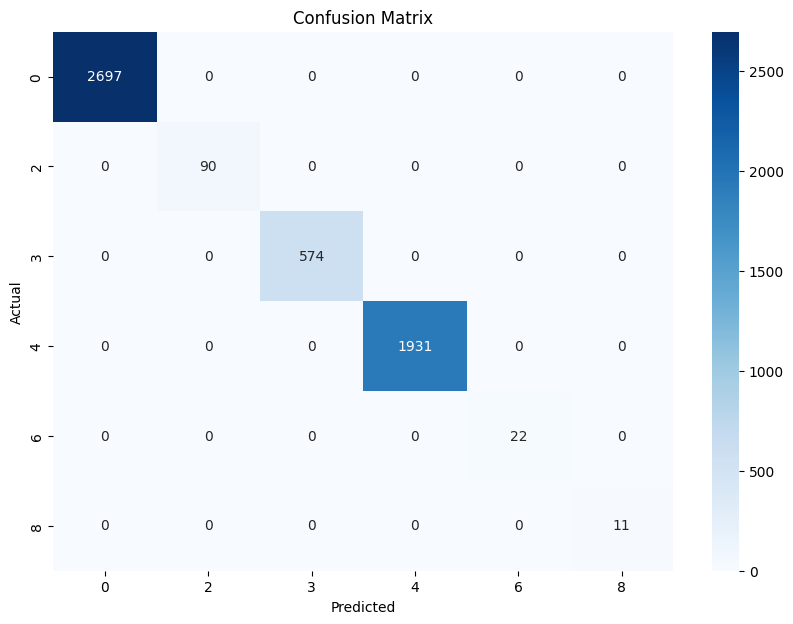

In [41]:
# Assuming X and Y are already defined as features and labels
Trainall = True
PipelineObject = False
shapValues = True

# Splitting the dataset
if Trainall:
    X_train, Y_train = X, Y
else:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print(f'Training features shape: {X_train.shape}')
    print(f'Training labels shape: {Y_train.shape}')
    print(f'Testing features shape: {X_test.shape}')
    print(f'Testing labels shape: {Y_test.shape}')

# Define numerical features and preprocessing steps
numerical_features = [c for c in X_train.columns]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num, df_out=True)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocess', mapper),
    ('rf', model)
])

print(f'Total samples for training: {X_train.shape[0]}')

# Fit the model
if PipelineObject:
    print('========= PipelineObject ==========')
    pipeline.fit(X_train, Y_train)
    if Trainall:
        y_pred = pipeline.predict(X_train)
        Y_true = Y_train
    else:
        y_pred = pipeline.predict(X_test)
        Y_true = Y_test
else:
    model.fit(X_train, Y_train)
    if Trainall:
        y_pred = model.predict(X_train)
        Y_true = Y_train
    else:
        y_pred = model.predict(X_test)
        Y_true = Y_test

# Evaluation
accuracy = accuracy_score(Y_true, y_pred)
balanced_acc = balanced_accuracy_score(Y_true, y_pred)
f1 = f1_score(Y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass

print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(Y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [42]:
if shapValues:
    if Trainall:
        X_test = X_train
        Y_test = Y_train

    if PipelineObject:
        explainer = shap.Explainer(pipeline['rf'], X_train)
        shap_values = explainer(X_test)
        
        shapeshap = np.shape(shap_values.values)
        print(f'In your case, your SHAP values have shape {shapeshap}, so you have SHAP values for multiple instances ({shapeshap[0]} instances in this case) and multiple features ({shapeshap[1]} features).')
    else:
        explainer_2 = shap.TreeExplainer(model)
        shap_values_2 = explainer_2.shap_values(X_test)

        shapeshap_2 = np.shape(shap_values_2)  
        print(f'In your case, your SHAP values have shape {shapeshap_2}, so you have SHAP values for multiple instances ({shapeshap_2[0]} instances in this case) and multiple features ({shapeshap_2[1]} features).')


In your case, your SHAP values have shape (5325, 85, 6), so you have SHAP values for multiple instances (5325 instances in this case) and multiple features (85 features).


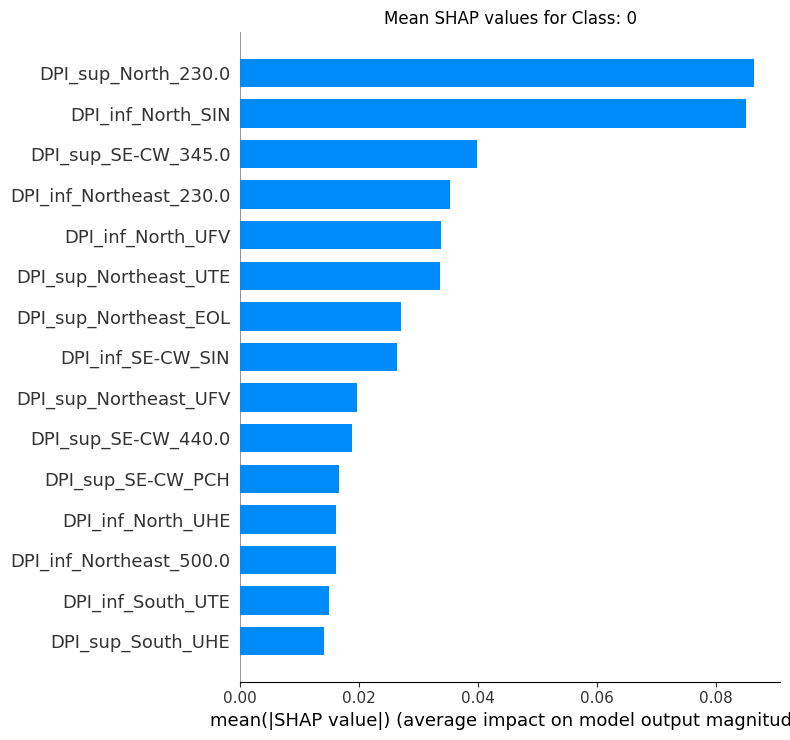

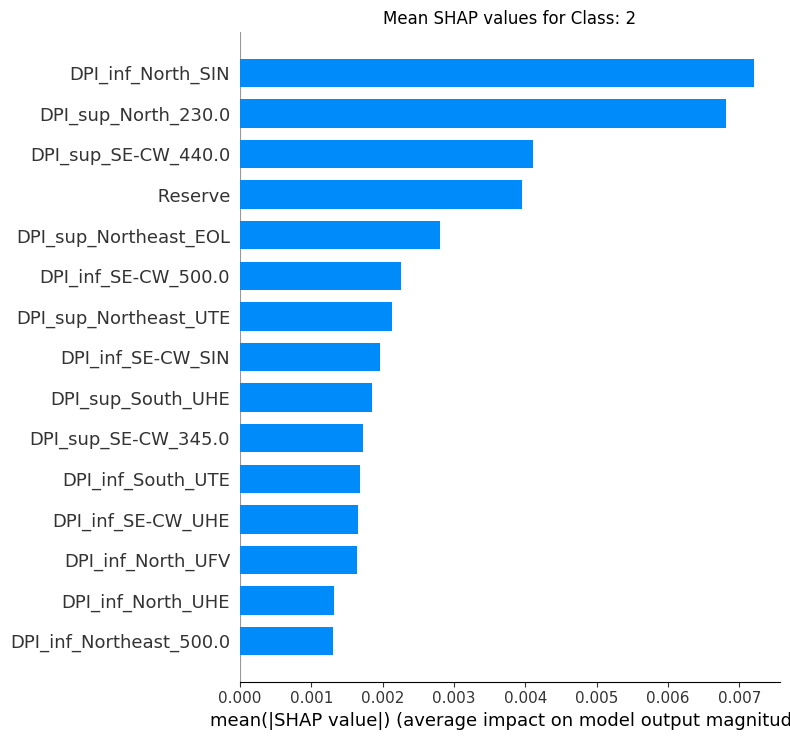

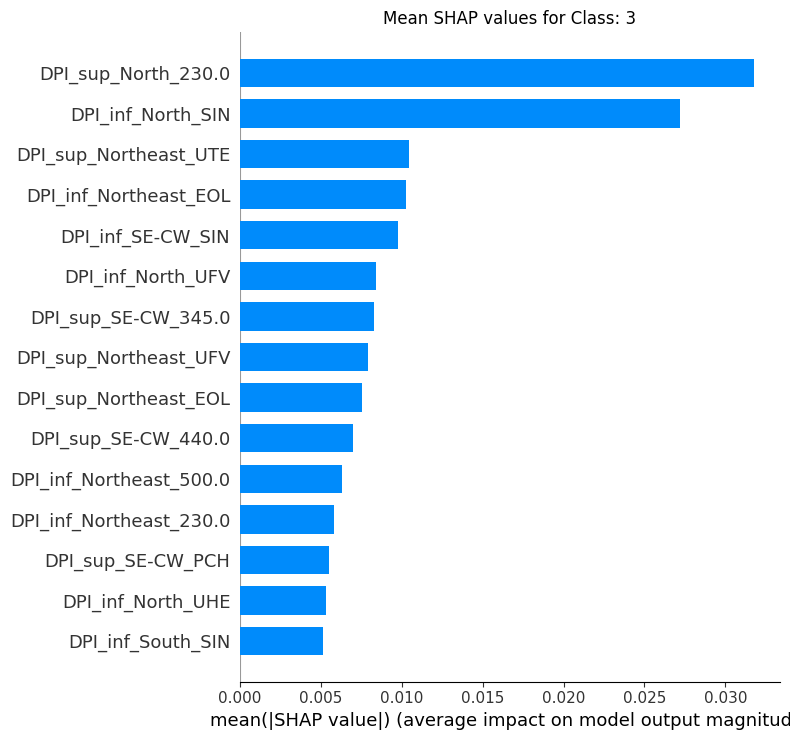

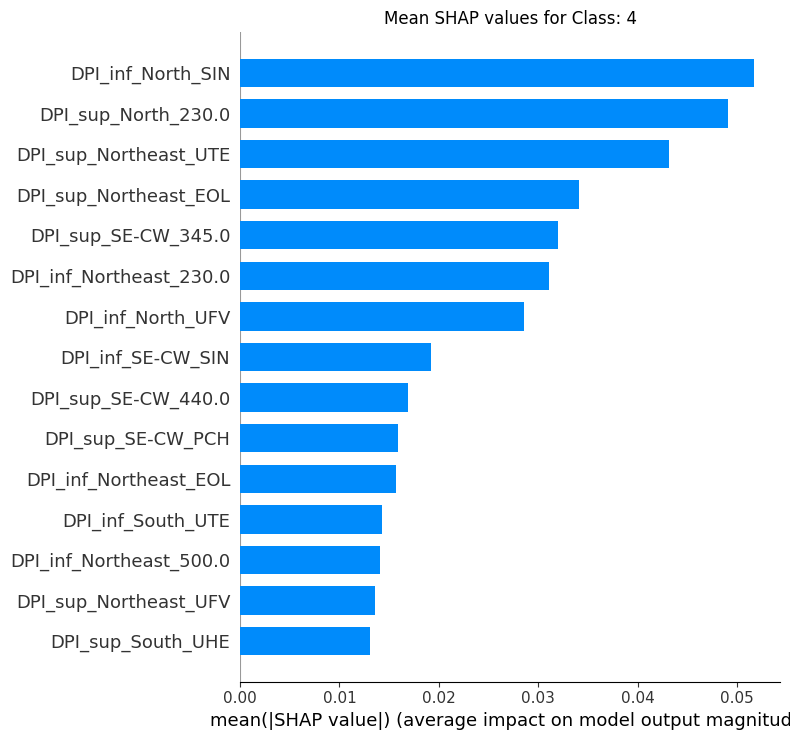

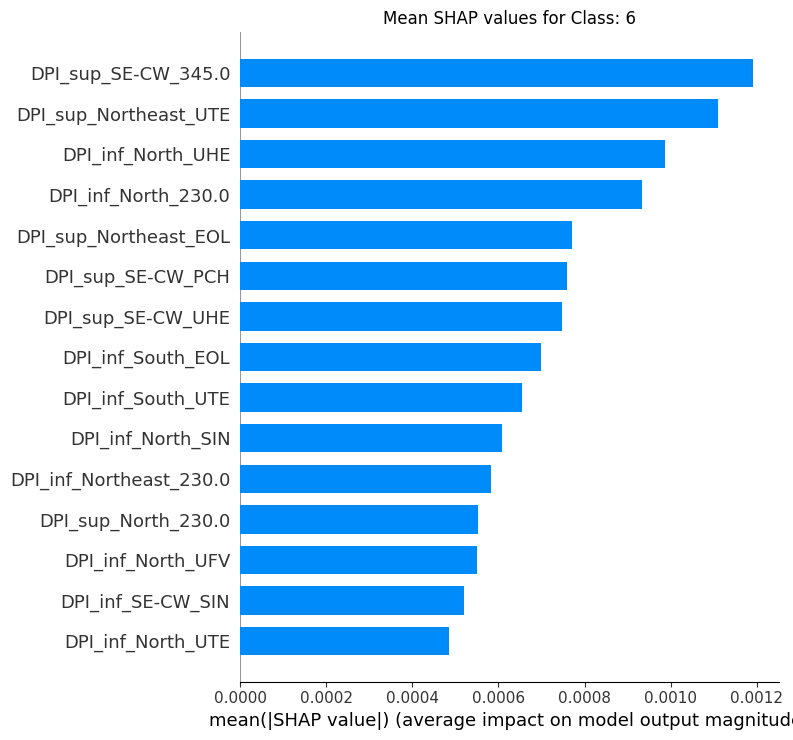

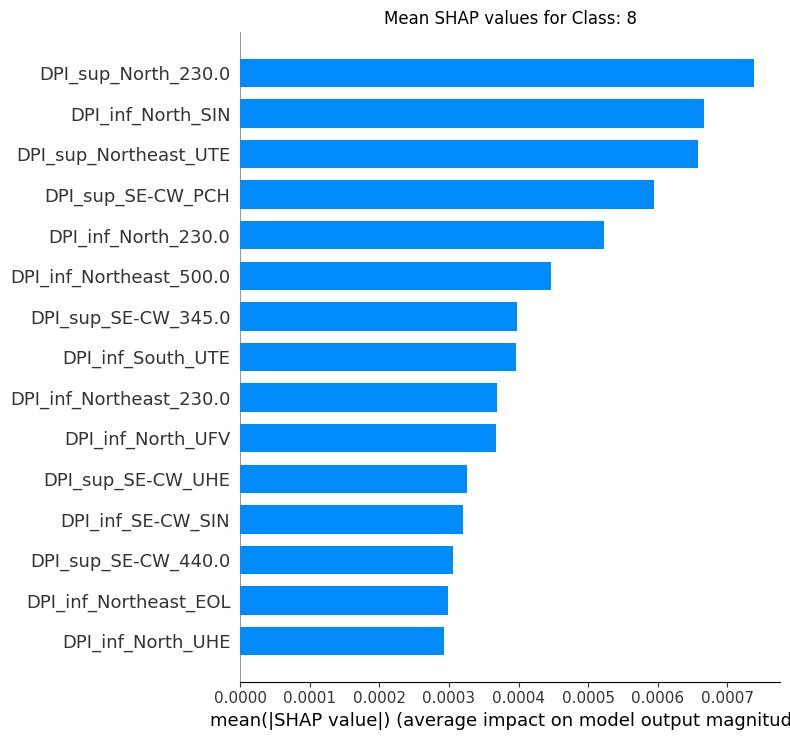

In [43]:
class_names = np.unique(Y_test)
for i, class_name in enumerate(class_names):
    plt.figure()  # Create a new figure for each class
    plt.title(f'Mean SHAP values for Class: {class_name}')  # Set the title
    shap.summary_plot(shap_values_2[:,:,i], X_test, plot_type="bar", max_display=15, feature_names=X_test.columns)
    plt.show()

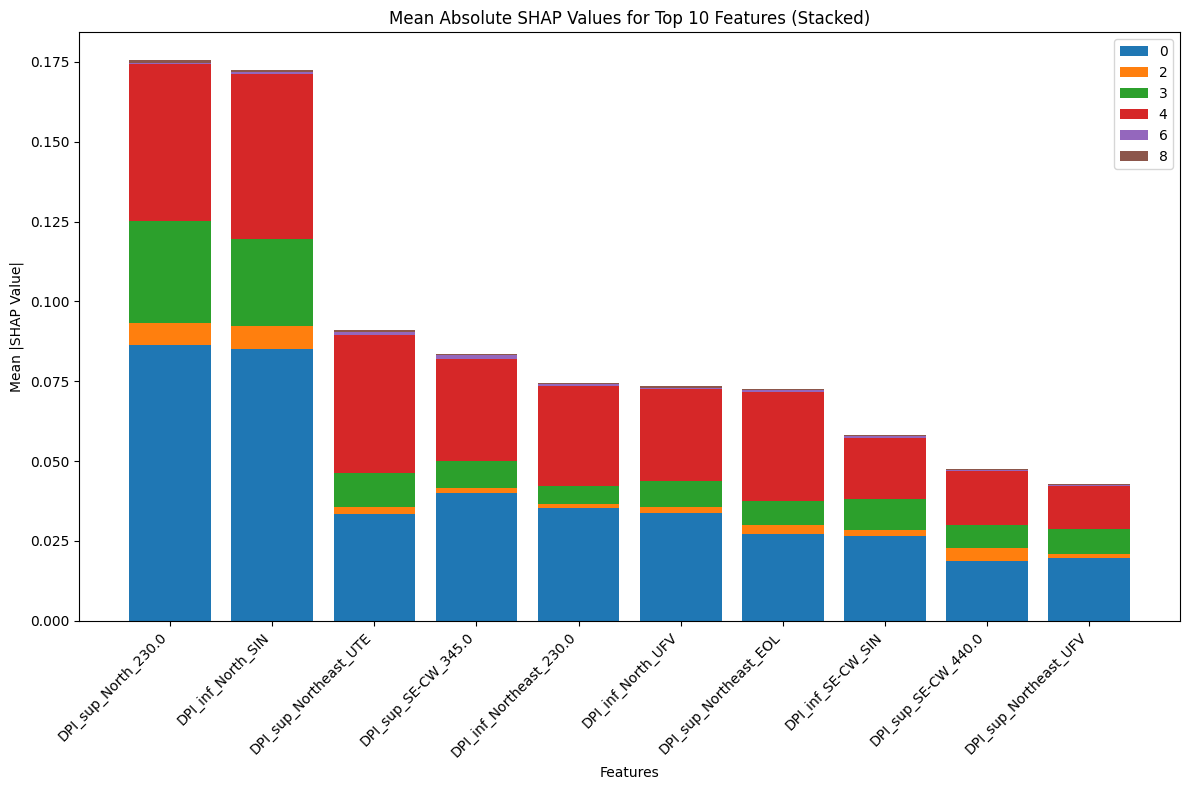

In [44]:
# Calculate mean absolute SHAP values for each feature per class
mean_shap_values_per_class = np.mean(np.abs(shap_values_2), axis=0)  # Shape: (123, 6)
# Calculate mean absolute SHAP values across all classes
mean_shap_values_agg = np.mean(mean_shap_values_per_class, axis=1)  # (123,)
# Get indices for sorting in descending order
sorted_indices = np.argsort(mean_shap_values_agg)[::-1]  # Descending order
# Get top 10 features and their SHAP values
top_10_features = X_test.columns[sorted_indices][:10]
top_10_shap_values = mean_shap_values_per_class[sorted_indices][:10, :]
# Plot stacked bar chart for top 10 features
plt.figure(figsize=(12, 8))
bottom = np.zeros(len(top_10_features))
for i, class_name in enumerate(class_names):
    plt.bar(
        top_10_features,
        top_10_shap_values[:, i],
        bottom=bottom,
        label=class_name,
    )
    bottom += top_10_shap_values[:, i]
# Add labels, title, and legend
plt.title('Mean Absolute SHAP Values for Top 10 Features (Stacked)')
plt.xlabel('Features')
plt.ylabel('Mean |SHAP Value|')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

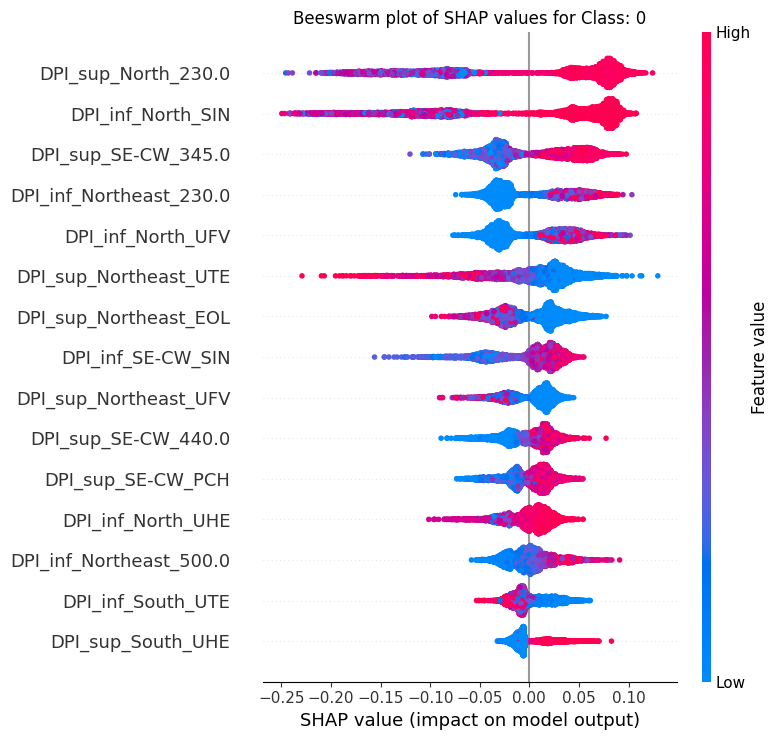

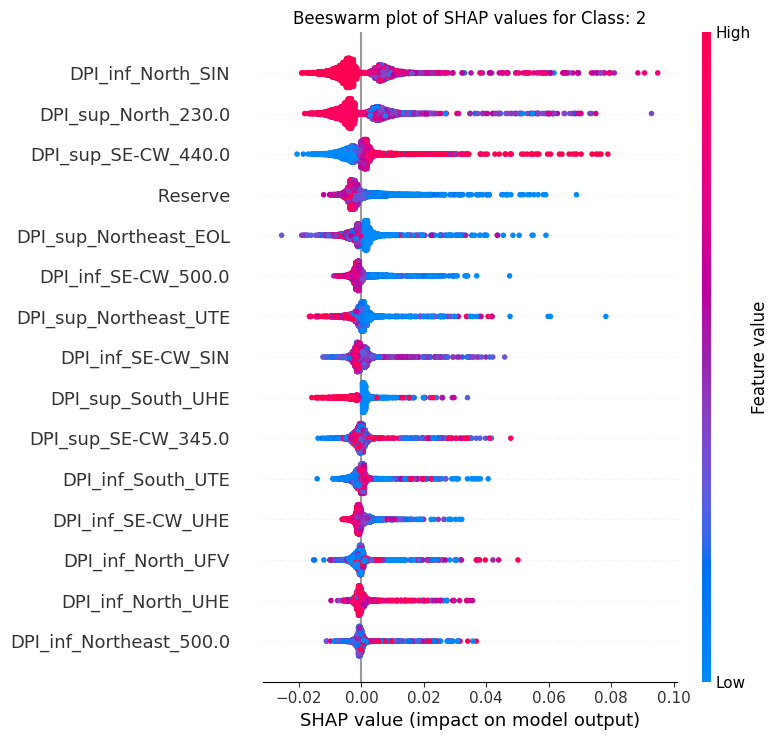

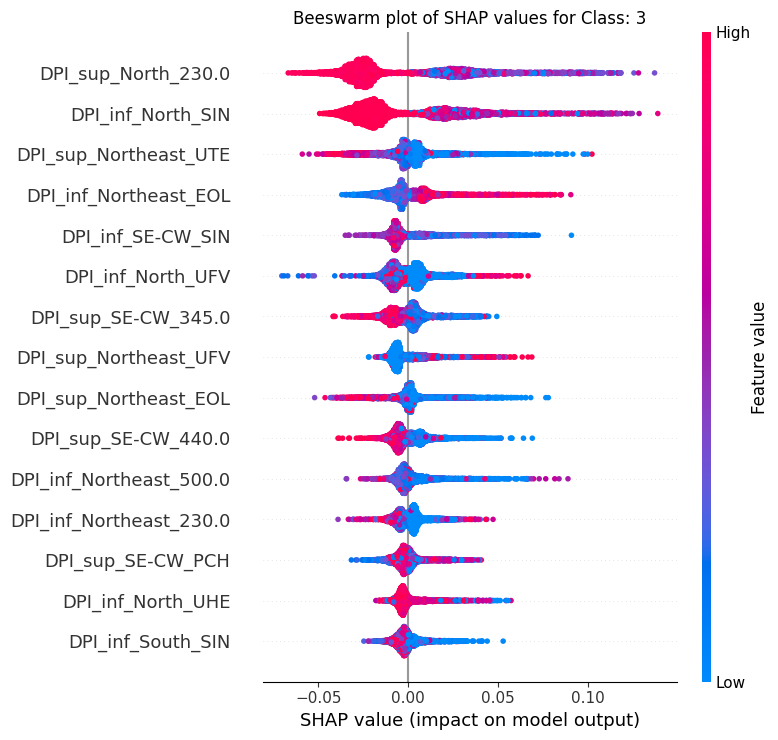

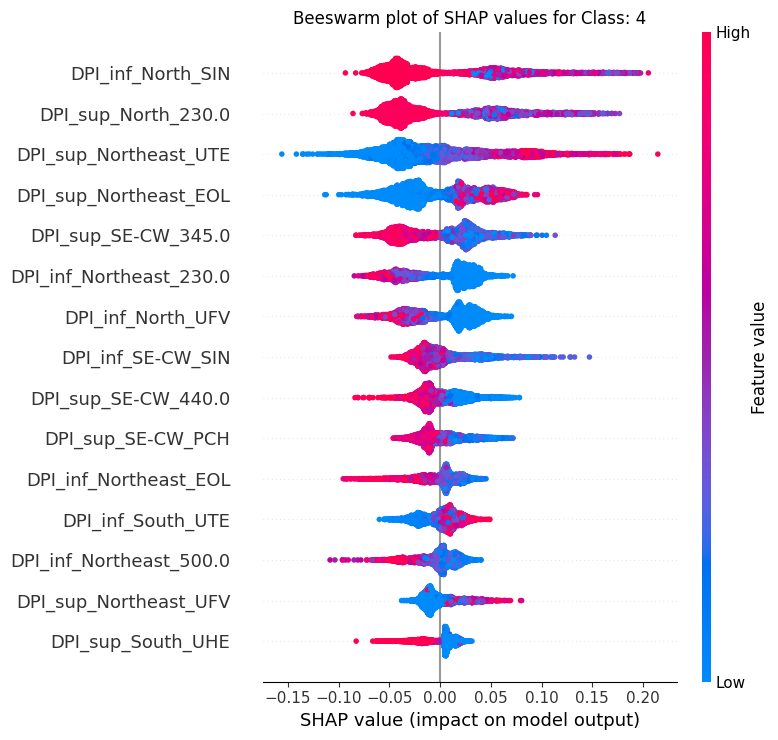

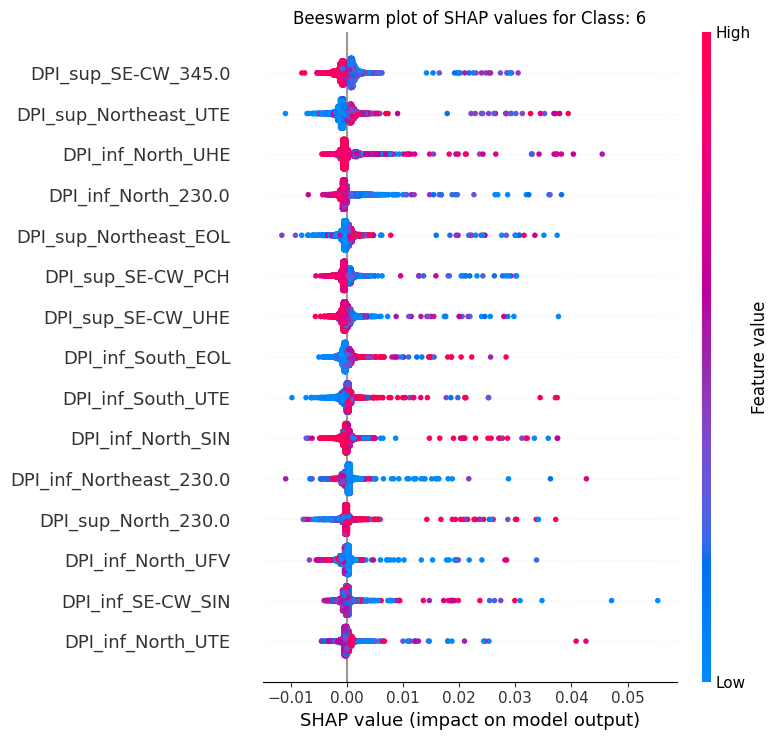

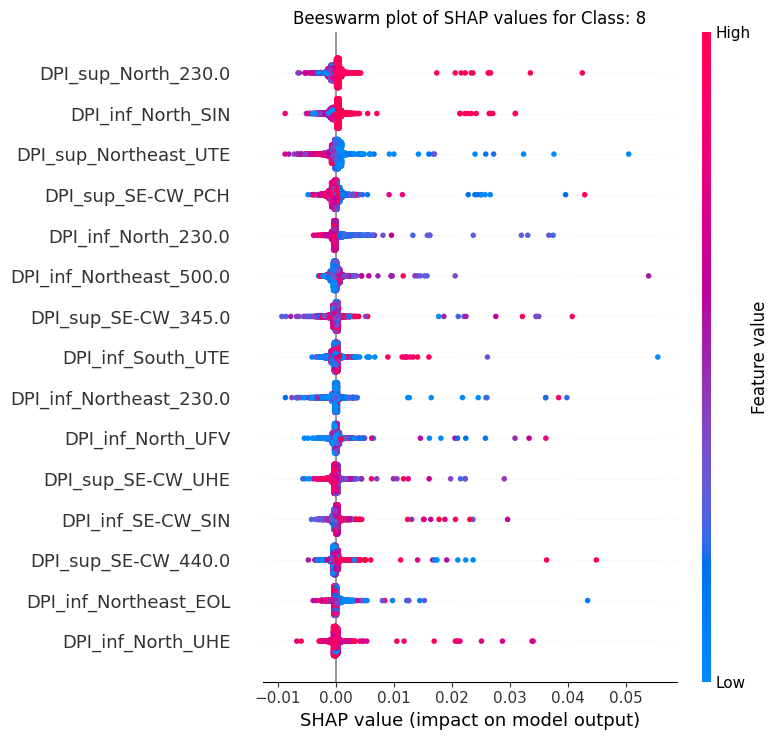

In [45]:
class_names = np.unique(Y_test)
for i, class_name in enumerate(class_names):
    plt.figure()  # Create a new figure for each class
    plt.title(f'Beeswarm plot of SHAP values for Class: {class_name}')
    shap.summary_plot(shap_values_2[:,:,i], X_test, max_display=15)
    plt.show()

In [46]:
# # Mean SHAP
# for label in np.unique(Y_test):
#     indices = np.where(Y_test == label)[0]
#     shapvalues_label = shap_values_2[indices]
#     # Mean SHAP
#     plt.title(f'Mean SHAP values for Cluster {label}')
#     shap.summary_plot(shapvalues_label[:,:,label], X_test, plot_type="bar", max_display=15)

#     # Beeswarm plot
#     plt.title(f'Beeswarm plot of SHAP values for Cluster {label}')
#     shap.summary_plot(shapvalues_label[:,:,label], X_test.iloc[indices], max_display=15)

In [47]:
# preds = model.predict(X_test)
# new_shape_values = []
# for i, pred in enumerate(preds):
#     # get shap values for predicted class
#     new_shape_values.append(shap_values_2[i][:,pred])

# new_shape_values = np.array(new_shape_values)
# print(new_shape_values.shape)

In [48]:
# shap.summary_plot(new_shape_values, X_test, plot_type="bar", max_display=15)
# shap.summary_plot(new_shape_values, X_test, max_display=15)

In [49]:
shap_values_2_explainer = explainer_2(X_test)

KeyboardInterrupt: 

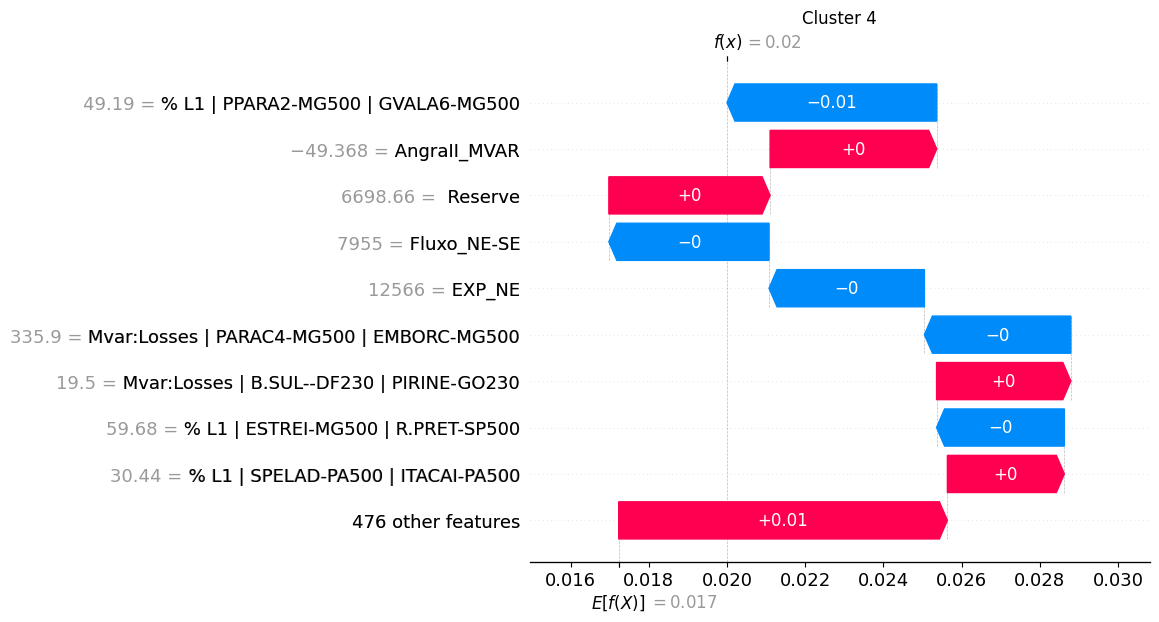

In [ ]:
ittem = 100
# label = Y_test[ittem]
label = model.predict(X_test)[ittem]
plt.title(f'Cluster {label}')
# shap.plots.waterfall(shap_values_2_explainer[ittem,:, label],max_display=10)
shap.plots.waterfall(shap_values_2_explainer[ittem,:, 1],max_display=10)